# Example: University

# Schema definition

The schema definition code is in the `university.py` module:

In [1]:
%pycat university.py

import datajoint as dj


schema = dj.Schema('university')


@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """
    
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> De

In [2]:
from university import *

[2025-01-15 02:04:29,161][INFO]: Connecting root@localhost:3306
[2025-01-15 02:04:29,179][INFO]: Connected root@localhost:3306


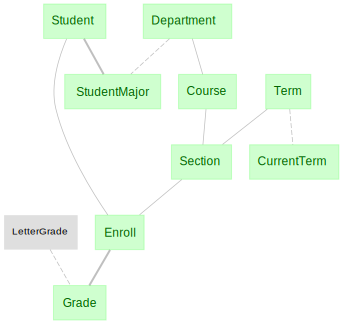

In [3]:
dj.Diagram(schema)

# Populate
Use `faker` to populate the database.

In [4]:
if Grade():
    raise RuntimeError(
        "Already populated. You only need to execute this notebook once.\n"
        "Drop the schema and restart the notebook to re-populate.")
    # schema.drop()

In [5]:
from tqdm import tqdm
import faker
import random
import datetime
fake = faker.Faker()
faker.Faker.seed(42)  # For reproducible results

In [6]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [7]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(1000,3000), yield_students()))

In [8]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1000,Allison,Hill,F,1994-01-07,819 Johnson Course,East William,AK,74064,+1-586-737-9402x6542
1001,James,Howard,M,2007-05-16,78161 Calderon River Suite 931,Lake Jeremyport,CO,31013,(547)452-5534x1928
1002,Debra,Schaefer,F,1996-05-02,503 Linda Locks,Carlshire,FM,94599,+1-876-772-4238x8496
1003,Zachary,Hicks,M,1992-05-01,22691 James Mountain,Tashatown,TX,94967,+1-645-414-6270
1004,Brian,Garrett,M,1994-11-10,52880 Burns Creek,Natashaport,IA,08093,001-411-671-8227
1005,Jeffrey,Holmes,M,1991-06-17,50983 Adrian Station,East Carloston,VI,43810,547.938.2997
1006,Cheryl,Davis,F,1995-01-14,7010 Chandler Union Apt. 333,Taylorburgh,KY,61138,478-810-8013
1007,Cindy,Morales,F,2000-02-05,64746 Moore Hill Apt. 098,Lake Leeton,OR,62994,220.381.2191x36193
1008,Bonnie,Brewer,F,1993-03-12,79911 William Curve,Nicolebury,MN,37854,+1-649-380-8412
1009,Patrick,Moore,M,1996-09-17,534 King Vista,North Cynthiaview,AZ,00965,(342)478-6801


In [9]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [10]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [11]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
1000,BIOL,2000-07-07
1001,PHYS,2019-01-27
1002,PHYS,2001-07-31
1004,MATH,2019-12-29
1007,MATH,2024-05-06
1008,CS,2015-02-23
1010,CS,2008-06-17
1011,PHYS,2010-06-24
1013,PHYS,2013-06-24
1015,BIOL,2001-07-02


In [12]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [13]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2025) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [14]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 2000/2000 [01:04<00:00, 31.13it/s]


In [15]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [16]:
Grade()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade
1000,MATH,2210,2021,Fall,d,B+
1002,BIOL,1006,1999,Fall,a,B+
1002,BIOL,1010,2003,Summer,a,A
1002,BIOL,2020,2003,Fall,a,C-
1002,BIOL,2021,2002,Summer,a,C
1002,BIOL,2030,2001,Spring,a,C+
1002,BIOL,2210,2001,Spring,a,A
1002,BIOL,2330,2001,Fall,a,C
1002,CS,2420,2002,Fall,a,C-
1002,CS,3500,2000,Spring,b,B


In [17]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1000,Allison,Hill,F,1994-01-07,819 Johnson Course,East William,AK,74064,+1-586-737-9402x6542
1001,James,Howard,M,2007-05-16,78161 Calderon River Suite 931,Lake Jeremyport,CO,31013,(547)452-5534x1928
1002,Debra,Schaefer,F,1996-05-02,503 Linda Locks,Carlshire,FM,94599,+1-876-772-4238x8496
1003,Zachary,Hicks,M,1992-05-01,22691 James Mountain,Tashatown,TX,94967,+1-645-414-6270
1004,Brian,Garrett,M,1994-11-10,52880 Burns Creek,Natashaport,IA,08093,001-411-671-8227
1005,Jeffrey,Holmes,M,1991-06-17,50983 Adrian Station,East Carloston,VI,43810,547.938.2997
1006,Cheryl,Davis,F,1995-01-14,7010 Chandler Union Apt. 333,Taylorburgh,KY,61138,478-810-8013
1007,Cindy,Morales,F,2000-02-05,64746 Moore Hill Apt. 098,Lake Leeton,OR,62994,220.381.2191x36193
1008,Bonnie,Brewer,F,1993-03-12,79911 William Curve,Nicolebury,MN,37854,+1-649-380-8412
1009,Patrick,Moore,M,1996-09-17,534 King Vista,North Cynthiaview,AZ,00965,(342)478-6801
